https://publiclab.org/notes/rmeister/06-10-2016/serial-communication-via-headphone-jack

- Obtain a window of the signal with a window length close to the number of samples per bit
- Multiply every sample with a sine and cosine of the frequency
- Sum up all products with the sine and separately all products of the cosine multiplication
- Square the two sums
- Add the squared sums
- Take the square root of the summation
- Save the value as first sample of the correlation
- Move the window one sample ahead and start over

Reference: https://github.com/publiclab/webjack/blob/master/matlab/softmodem_read.m

relevant documentation for 'audioread()', used in softmodem_read.m: https://www.mathworks.com/help/matlab/ref/audioread.html

"[y,Fs] = audioread(filename) reads data from the file named filename, and returns sampled data, y, and a sample rate for that data, Fs."

Recordings: https://github.com/publiclab/webjack/tree/master/matlab/recordings

http://thehub.musiciansfriend.com/tech-tips/sample-rate-and-bit-depth-an-introduction-to-sampling?src=3SOSWXXA



In [2]:
import matplotlib.pyplot as plt
import numpy as np
import wave
import sys

In [3]:
spf = wave.open('webjack.wav','r')

In [4]:
signal=spf.readframes(-1)

In [5]:
framerate=spf.getframerate()

In [6]:
samplewidth=spf.getsampwidth()

In [7]:
signal=np.fromstring(signal,'Int16')

In [8]:
signal=signal/np.max(signal)

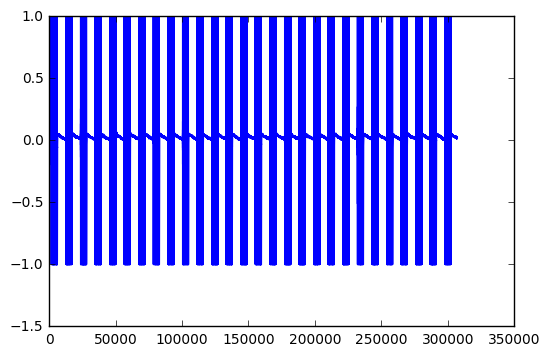

In [9]:
plt.plot(signal)
plt.show()


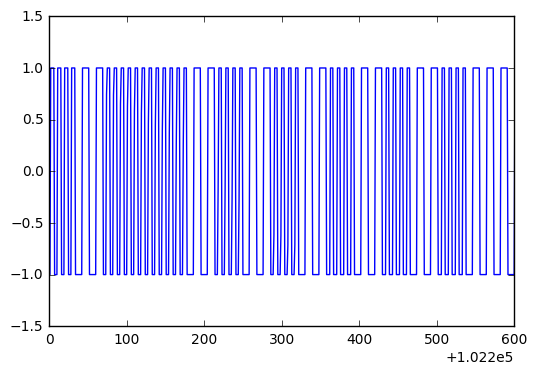

In [10]:
plt.plot(signal)
plt.xlim(102200,102800)
plt.ylim(-1.5,1.5)
plt.show()


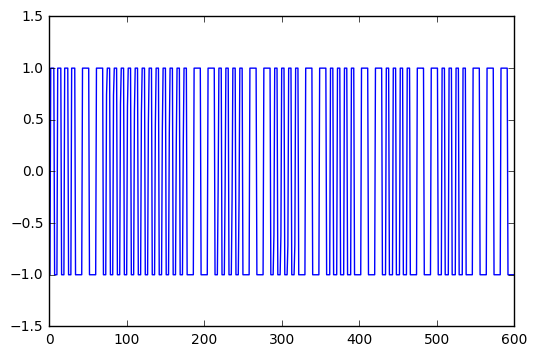

In [11]:
sub_sig=signal[102200:102800]
plt.plot(sub_sig)
plt.ylim(-1.5,1.5)
plt.show()

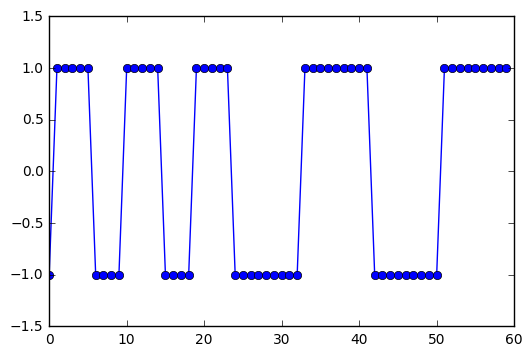

In [12]:
sub_sub_sig=signal[102210:102270]
plt.plot(sub_sub_sig,'-o')
plt.ylim(-1.5,1.5)
plt.show()

In [13]:
framerate

44100

In [14]:
samplewidth

2

In [15]:
fnyquist = framerate/2

In [16]:
windowsize=8 



justification for windowsize? From above: "Obtain a window of the signal with a window length close to the number of samples per bit"

maybe 'number of samples per bit' means -- how many samples we expect to be in each bit.  looking up at figure above, 8 does seem right.  so this is then determined by softserial send rate.  

try this:

function [event,c_l,c_h] = demod(s, fs, windowsize, f_low, f_high, baud)

	event = zeros(size(s));
	fnyquist = fs/2;
	
	%% filtering
	cutoff_low = f_low*0.8/fnyquist;
	cutoff_high = f_high*1.2/fnyquist;
	[b,a] = butter(1, [cutoff_low, cutoff_high]);
	s_filt = filter(b,a,s);
	
	%% correlation with lower and upper frequency
	c_l = correlate(s_filt, f_low, fs, windowsize);
	c_h = correlate(s_filt, f_high, fs, windowsize);
	

	%% difference of the correlations = recovered signal
	%% filtering signals with f > baudrate
	% cutoff_high = baud/fnyquist;
	% [b,a] = butter(1, cutoff_high);
	corr_diff = c_h - c_l;
	% corr_diff = filter(b,a, corr_diff);	% resulting signal looks better without filtering
	corr_diff /= max(corr_diff);

	event = corr_diff;
	% fftplots(s, s_filt, fs);

end

f butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


-----

butterworth: http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.signal.butter.html

good info on implementing: https://scipy.github.io/old-wiki/pages/Cookbook/ButterworthBandpass

-----


generating FFT

http://docs.scipy.org/doc/scipy/reference/tutorial/fftpack.html

discrete fourier transform: http://practicalcryptography.com/miscellaneous/machine-learning/intuitive-guide-discrete-fourier-transform/


1225 bit/s, 4900 and 7350 Hz --- default

In [22]:
f_low=4900
f_high=7350
baud=1225

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:10: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


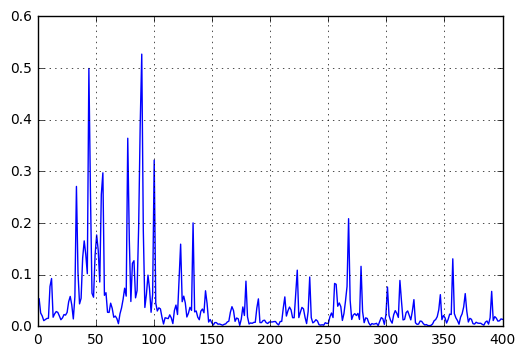

In [23]:
from scipy.fftpack import fft
s=sub_sig
N=len(s)
T=1/800.
x=np.linspace(0.0,N*T,N)
y=s
yf=fft(y)
xf=np.linspace(0.0,1.0/(2.0*T),N/2)
import matplotlib.pyplot as plt
plt.plot(xf,2.0/N * np.abs(yf[0:N/2]))
plt.grid()
plt.show()

note -- maybe without having tweaked the x units, the math works out to be off by some factor of ten ... b/c the beaks could be interpreted as ~ 49, and ~ 73, which could correspond to 4900 and 7350 Hz.



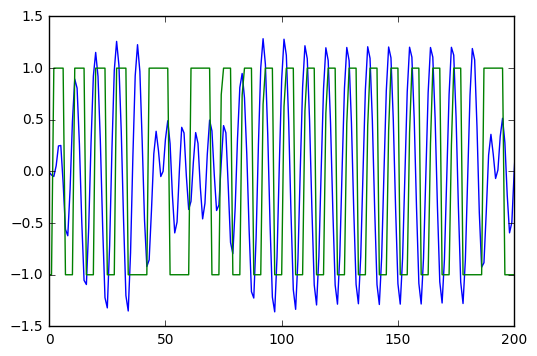

In [56]:
from scipy import signal
from scipy import correlate
fs=framerate
fnyquist = fs/2;
cutoff_low = f_low*0.8/fnyquist;
cutoff_high = f_high*1.2/fnyquist;
b, a = signal.butter(4, [cutoff_low,cutoff_high],btype='band')

s_filt=lfilter(b,a,sub_sig)


plt.plot(s_filt)
plt.plot(sub_sig)
plt.xlim(0,200)
plt.show()

# Background re: fft and butterworth filters

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


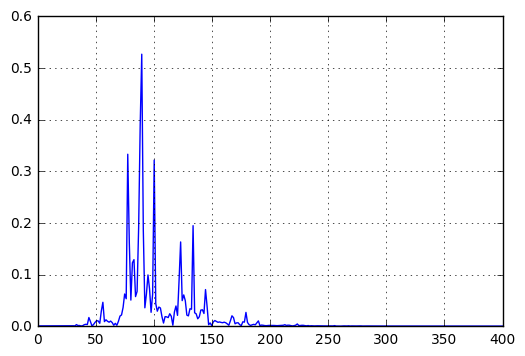

In [53]:
from scipy.fftpack import fft
s=sub_sig
N=len(s)
T=1/800.
x=np.linspace(0.0,N*T,N)
yf=fft(y)
xf=np.linspace(0.0,1.0/(2.0*T),N/2)
import matplotlib.pyplot as plt
plt.plot(xf,2.0/N * np.abs(yf[0:N/2]))
plt.grid()
plt.show()

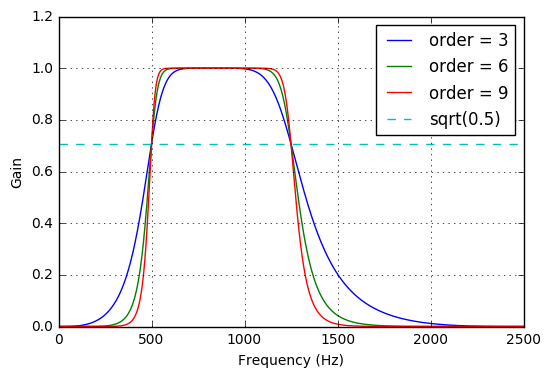

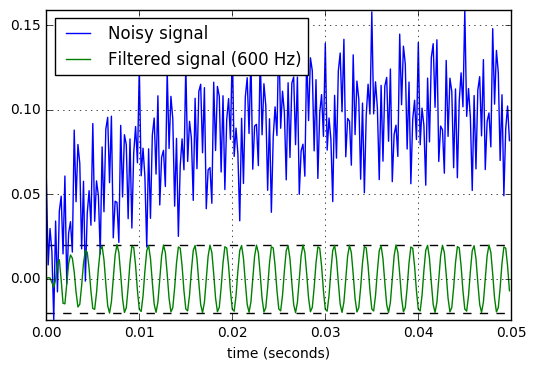

In [41]:
from scipy.signal import butter, lfilter


def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y


if __name__ == "__main__":
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.signal import freqz

    # Sample rate and desired cutoff frequencies (in Hz).
    fs = 5000.0
    lowcut = 500.0
    highcut = 1250.0

    # Plot the frequency response for a few different orders.
    plt.figure(1)
    plt.clf()
    for order in [3, 6, 9]:
        b, a = butter_bandpass(lowcut, highcut, fs, order=order)
        w, h = freqz(b, a, worN=2000)
        plt.plot((fs * 0.5 / np.pi) * w, abs(h), label="order = %d" % order)

    plt.plot([0, 0.5 * fs], [np.sqrt(0.5), np.sqrt(0.5)],
             '--', label='sqrt(0.5)')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Gain')
    plt.grid(True)
    plt.legend(loc='best')

    # Filter a noisy signal.
    T = 0.05
    nsamples = T * fs
    t = np.linspace(0, T, nsamples, endpoint=False)
    a = 0.02
    f0 = 600.0
    x = 0.1 * np.sin(2 * np.pi * 1.2 * np.sqrt(t))
    x += 0.01 * np.cos(2 * np.pi * 312 * t + 0.1)
    x += a * np.cos(2 * np.pi * f0 * t + .11)
    x += 0.03 * np.cos(2 * np.pi * 2000 * t)
    plt.figure(2)
    plt.clf()
    plt.plot(t, x, label='Noisy signal')

    y = butter_bandpass_filter(x, lowcut, highcut, fs, order=6)
    plt.plot(t, y, label='Filtered signal (%g Hz)' % f0)
    plt.xlabel('time (seconds)')
    plt.hlines([-a, a], 0, T, linestyles='--')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc='upper left')

    plt.show()

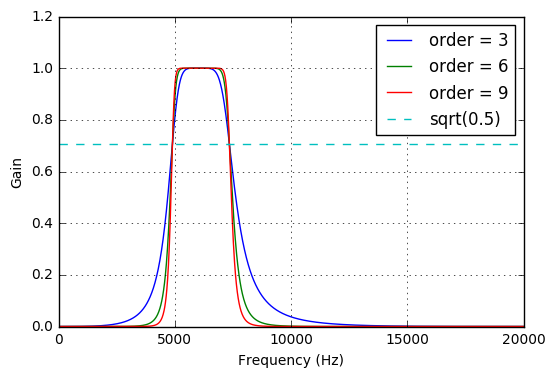

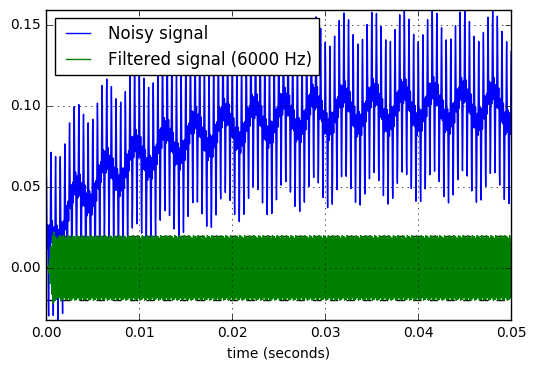

In [48]:
from scipy.signal import butter, lfilter


def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y


if __name__ == "__main__":
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.signal import freqz

    # Sample rate and desired cutoff frequencies (in Hz).
    fs = 40000.0
    lowcut = 4900
    highcut = 7350

    # Plot the frequency response for a few different orders.
    plt.figure(1)
    plt.clf()
    for order in [3, 6, 9]:
        b, a = butter_bandpass(lowcut, highcut, fs, order=order)
        w, h = freqz(b, a, worN=2000)
        plt.plot((fs * 0.5 / np.pi) * w, abs(h), label="order = %d" % order)

    plt.plot([0, 0.5 * fs], [np.sqrt(0.5), np.sqrt(0.5)],
             '--', label='sqrt(0.5)')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Gain')
    plt.grid(True)
    plt.legend(loc='best')

    # Filter a noisy signal.
    T = 0.05
    nsamples = T * fs
    t = np.linspace(0, T, nsamples, endpoint=False)
    a = 0.02
    f0 = 6000.0
    x = 0.1 * np.sin(2 * np.pi * 1.2 * np.sqrt(t))
    x += 0.01 * np.cos(2 * np.pi * 312 * t + 0.1)
    x += a * np.cos(2 * np.pi * f0 * t + .11)
    x += 0.03 * np.cos(2 * np.pi * 2000 * t)
    plt.figure(2)
    plt.clf()
    plt.plot(t, x, label='Noisy signal')

    y = butter_bandpass_filter(x, lowcut, highcut, fs, order=6)
    plt.plot(t, y, label='Filtered signal (%g Hz)' % f0)
    plt.xlabel('time (seconds)')
    plt.hlines([-a, a], 0, T, linestyles='--')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc='upper left')

    plt.show()

In [45]:
cutoff_low

0.17777777777777778

In [46]:
cutoff_high

0.4